<a href="https://colab.research.google.com/github/podyssea/RecommenderSystems/blob/main/IR_Exercise_1_2210049p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval Exercise 1 Notebook

This is the template notebook for Exercise 1. The specification for the exercise and the corresponding Exercise 1 Quiz submission instance are available on the Moodle page of the course.

## Assumed Knowledge

This Exercise assumes knowedge of Pandas and PyTerrier from the introductory lab. The relevant parts of the PyTerrier documentation are:
 - [Using Terrier indices in PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html)
 - [Terrier Retrieval using PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html), e.g. BatchRetrieve
 - [Operators on PyTerrier transformers](https://pyterrier.readthedocs.io/en/latest/operators.html)


## Setup

In [ ]:
!pip install python-terrier

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

import pandas as pd
pd.set_option('display.max_colwidth', 150)

# Datasets for Ex1

For Exercise 1, we'll be using the Datasets API to obtain the files we need for this exercise. PyTerrier actually provides many datasets. You can list all of them using `pt.list_datasets()`.

In [ ]:
pt.list_datasets()

,dataset,topics,qrels,corpus,index
0,50pct,"[training, validation]","[training, validation]",None,True
1,antique,"[train, test]","[train, test]",True,None
2,vaswani,True,True,True,True
3,trec-deep-learning-docs,"[train, dev, test, test-2020, leaderboard-2020]","[train, dev, test]",True,None
4,trec-deep-learning-passages,"[train, dev, eval, test-2019]","[train, dev, test-2019]",True,None
5,trec-robust-2004,True,True,None,None
6,trec-robust-2005,True,True,None,None
7,trec-terabyte,"[2004, 2005, 2006, 2004-2006, 2006-np, 2005-np]","[2004, 2005, 2006, 2004-2006, 2005-np, 2006-np]",None,None
8,trec-precision-medicine,"[2017, 2018, 2019, 2020]","[qrels-2017-abstracts, qrels-2017-abstracts-sample, qrels-2017-trials, qrels-2018-abstracts, qrels-2018-abstracts-sample, qrels-2018-trials, qrels...",None,None
9,trec-covid,"[round1, round2, round3, round4, round5]","[round1, round2, round3, round3-cumulative, round4, round4-cumulative, round5]","[round4, round5]",None


There are several sets of files we need for Exercise 1:
 - the index for 50% of the TREC GOV corpus. We provide this through the "50pct" dataset, but you will need the username and password that we assigned to you after you signed the user license agreement.
 - the topics (queries) and qrels (relevance assessments) for evaluating the performance of our search engine. These come from the "trec-wt-2004" dataset.

Update your username and password. DO NOT SHARE your login details with other students - all they need to do is submit a signed user agreement to us.



In [ ]:
USERNAME = "TODO"
PASSWORD = "TODO"

dotgov_50pct = pt.get_dataset("50pct", user='2210049p', password='e54de6e4')
dotgov_topicsqrels =  pt.get_dataset("trec-wt-2004")

The size of the "50pct" index is 800MB - this will take a minute or so for Colab to download before we load it for the first time.

In [ ]:
indexref = dotgov_50pct.get_index()
index = pt.IndexFactory.of(indexref)



# Q1

Using this setup, you now have sufficient knowledge from the introductory lab to complete Q1 of this assessed exercise, namely to get the indexing statistics of the "50pct" collection.

In [ ]:
#Get index statistics of collection
print(index.getCollectionStatistics().toString())

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 0
Number of tokens: 572916194
Field names: []
Positions:   false



# Retrieval & Evaluation

In our experiments, we are using three sets of topics: "hp", "np" and "td". We can obtain them from the `dotgov_topicsqrels` dataset as follows:

In [ ]:
topics = dotgov_topicsqrels.get_topics(variant="hp")
topics.head(5)

,qid,query
0,6,philadelphia streets
1,7,togo embassy
2,9,baltimore
3,17,secure linux
4,29,grand canyon monitoring and research center


Let's create a simple TF_IDF retriever - we will use this for demonstrating IR evaluation using PyTerrier.

In [ ]:
retr = pt.BatchRetrieve(index, wmodel="TF_IDF")

Let's see how we can actually evaluate our TF_IDF retrieval system. Firstly, we'll need the qrels.

In [ ]:
qrels = dotgov_topicsqrels.get_qrels(variant='hp')

We can use `pt.Utils.evaluate(results, qrels)` to evaluate the results    
Args:    
 - metrics, `default = ["map", ndcg"]`, select the evaluation metrics    
 - perquery, `default = False`, select whether to show the mean of the metrics over all queries or the metrics for each query

In [ ]:
res = retr.transform(topics)
eval = pt.Utils.evaluate(res, qrels, metrics=["map"])
eval

{'map': 0.20894845478512017}

However, creating the res dataframe for each system in turn, and then evaluating it is laborious. We strongly recommend using [`pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to evaluate one or more retrieval systems at once, in a declarative manner. 

Take the time to read the [documentation for `pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to understand its available functionality. Q2-Q4 will all require that you adapt the arguments to `pt.Experiment()` and use its output in different ways.

In [ ]:
pt.Experiment(
    [retr],
     dotgov_topicsqrels.get_topics(variant='hp'),
     dotgov_topicsqrels.get_qrels(variant='hp'), 
     eval_metrics=['map']
)

,name,map
0,BR(TF_IDF),0.208948


# Q2(a)

You now have enough information to complete Q2(a) of the assessed exercise. 

*Hint*: We encourage you to write your own functions that perform reusable operations across different topic sets.

In [ ]:
#Get the indexes for different models
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [ ]:
#define two functions for comparing the baseline model with bm25 and pl2

#for baseline we use TF_IDF
#topic can se be set as desired
def baseline_bm25(baseline_model, model2, topic):
  result = pt.Experiment(
    [baseline_model, model2],
    dotgov_topicsqrels.get_topics(variant=topic),
    dotgov_topicsqrels.get_qrels(variant=topic),
    eval_metrics=["map"],
    names=["TF_IDF", "BM25"],
    baseline = 0)
  return result


def baseline_pl2(baseline_model, model2, topic):
  result = pt.Experiment(
    [baseline_model, model2],
    dotgov_topicsqrels.get_topics(variant=topic),
    dotgov_topicsqrels.get_qrels(variant=topic),
    eval_metrics=["map"],
    names=["TF_IDF", "PL2"],
    baseline = 0)
  return result

In [ ]:
baseline_bm25(tfidf, bm25, "hp")

,name,map,map +,map -,map p-value
0,TF_IDF,0.208948,NaN,NaN,NaN
1,BM25,0.218569,11.0,20.0,0.463462


In [ ]:
baseline_bm25(tfidf, bm25, "np")

,name,map,map +,map -,map p-value
0,TF_IDF,0.447715,NaN,NaN,NaN
1,BM25,0.441566,6.0,11.0,0.066561


In [ ]:
baseline_bm25(tfidf, bm25, "td")

,name,map,map +,map -,map p-value
0,TF_IDF,0.069793,NaN,NaN,NaN
1,BM25,0.070254,26.0,31.0,0.249291


In [ ]:
baseline_pl2(tfidf, pl2, "hp")

,name,map,map +,map -,map p-value
0,TF_IDF,0.208948,NaN,NaN,NaN
1,PL2,0.225110,17.0,36.0,0.448418


In [ ]:
baseline_pl2(tfidf, pl2, "np")

,name,map,map +,map -,map p-value
0,TF_IDF,0.447715,NaN,NaN,NaN
1,PL2,0.439182,17.0,20.0,0.654736


In [ ]:
baseline_pl2(tfidf, pl2, "td")

,name,map,map +,map -,map p-value
0,TF_IDF,0.069793,NaN,NaN,NaN
1,PL2,0.069525,39.0,36.0,0.862098


In [ ]:
#define a function to return the results for the comparison of the three models
# on the different topic sets hp,np,td
def map(model1, model2, model3, topic):
  result = pt.Experiment(
    [model1, model2, model3],
    dotgov_topicsqrels.get_topics(variant=topic),
    dotgov_topicsqrels.get_qrels(variant=topic),
    eval_metrics=["map"],
    names=["TF_IDF", "PL2", "BM25"])
  return result

In [ ]:
hp_map = map(tfidf, pl2, bm25, "hp")
hp_map

,name,map
0,TF_IDF,0.208948
1,PL2,0.225110
2,BM25,0.218569


In [ ]:
np_map = map(tfidf, pl2, bm25, "np")
np_map

,name,map
0,TF_IDF,0.447715
1,PL2,0.439182
2,BM25,0.441566


In [ ]:
td_map = map(tfidf, pl2, bm25, "td")
td_map

,name,map
0,TF_IDF,0.069793
1,PL2,0.069525
2,BM25,0.070254


# Print results of MAPs of each model on each topic set

In [ ]:
#print the average map of the three topic sets for TF_IDF
print((hp_map[hp_map['name'] == 'TF_IDF']['map'] + 
np_map[hp_map['name'] == 'TF_IDF']['map'] + 
td_map[hp_map['name'] == 'TF_IDF']['map'])/3)

0    0.242152
Name: map, dtype: float64


In [ ]:
#print the average map of the three topic sets for PL2
print((hp_map[hp_map['name'] == 'PL2']['map'] + 
np_map[hp_map['name'] == 'PL2']['map'] + 
td_map[hp_map['name'] == 'PL2']['map'])/3)

1    0.244606
Name: map, dtype: float64


In [ ]:
#print the average map of the three topic sets for BM25
print((hp_map[hp_map['name'] == 'BM25']['map'] + 
np_map[hp_map['name'] == 'BM25']['map'] + 
td_map[hp_map['name'] == 'BM25']['map'])/3)

2    0.243463
Name: map, dtype: float64


#Q2(b) 

Question 2(b) is concerned with drawing interpolated recall precision curves. You will need to use the `"iprec_at_recall"` measure.

*Hint*: Matplotlib has a [`savefig()`](https://chartio.com/resources/tutorials/how-to-save-a-plot-to-a-file-using-matplotlib/#the-savefig-method) function for saving a PNG of a figure.

In [ ]:
#define a function to calculate the iprec_at_recall values for the three models
#on the different topic sets individually
def iprec_at_recall(model1, model2, model3, topic, metric):
  result = pt.Experiment(
    [model1, model2, model3],
    dotgov_topicsqrels.get_topics(variant=topic),
    dotgov_topicsqrels.get_qrels(variant=topic),
    eval_metrics=[metric],
    names=["TF_IDF", "PL2", "BM25"])
  return result

In [ ]:
#hp precision-recall values for the three models
hp_recall = iprec_at_recall(tfidf, pl2, bm25, "hp", "iprec_at_recall")
hp_recall

,name,iprec_at_recall_0.00,iprec_at_recall_0.10,iprec_at_recall_0.20,iprec_at_recall_0.30,iprec_at_recall_0.40,iprec_at_recall_0.50,iprec_at_recall_0.60,iprec_at_recall_0.70,iprec_at_recall_0.80,iprec_at_recall_0.90,iprec_at_recall_1.00
0,TF_IDF,0.213123,0.213123,0.213123,0.213123,0.213123,0.213123,0.206457,0.206457,0.206457,0.206457,0.206457
1,PL2,0.229183,0.229183,0.229183,0.229183,0.229183,0.229183,0.222516,0.222516,0.222516,0.222516,0.222516
2,BM25,0.222756,0.222756,0.222756,0.222756,0.222756,0.222756,0.216090,0.216090,0.216090,0.216090,0.216090


In [ ]:
#np precision-recall values for the three models
np_recall = iprec_at_recall(tfidf, pl2, bm25, "np", "iprec_at_recall")
np_recall

,name,iprec_at_recall_0.00,iprec_at_recall_0.10,iprec_at_recall_0.20,iprec_at_recall_0.30,iprec_at_recall_0.40,iprec_at_recall_0.50,iprec_at_recall_0.60,iprec_at_recall_0.70,iprec_at_recall_0.80,iprec_at_recall_0.90,iprec_at_recall_1.00
0,TF_IDF,0.449847,0.449847,0.449847,0.449847,0.449847,0.449847,0.446609,0.446609,0.446609,0.446609,0.446609
1,PL2,0.443162,0.443162,0.443162,0.443162,0.443162,0.443162,0.436496,0.436496,0.436496,0.436496,0.436496
2,BM25,0.443682,0.443682,0.443682,0.443682,0.443682,0.443682,0.440296,0.440296,0.440296,0.440296,0.440296


In [ ]:
#td precision-recall values for the three models
td_recall = iprec_at_recall(tfidf, pl2, bm25, "td", "iprec_at_recall")
td_recall

,name,iprec_at_recall_0.00,iprec_at_recall_0.10,iprec_at_recall_0.20,iprec_at_recall_0.30,iprec_at_recall_0.40,iprec_at_recall_0.50,iprec_at_recall_0.60,iprec_at_recall_0.70,iprec_at_recall_0.80,iprec_at_recall_0.90,iprec_at_recall_1.00
0,TF_IDF,0.276114,0.175919,0.128181,0.101728,0.086377,0.057259,0.041509,0.024809,0.012481,0.006777,0.005552
1,PL2,0.270838,0.164414,0.124698,0.106343,0.087748,0.058264,0.043410,0.027931,0.012583,0.006585,0.005594
2,BM25,0.274648,0.176544,0.128443,0.103514,0.087262,0.058282,0.042106,0.025099,0.012327,0.006695,0.005591


In [ ]:
import matplotlib.pyplot as plot
from google.colab import files

In [ ]:
#set indexes for all dataframes produced to display the graphs for each topic set
hp_recall.set_index('name', inplace=True)
np_recall.set_index('name', inplace=True)
td_recall.set_index('name', inplace=True)

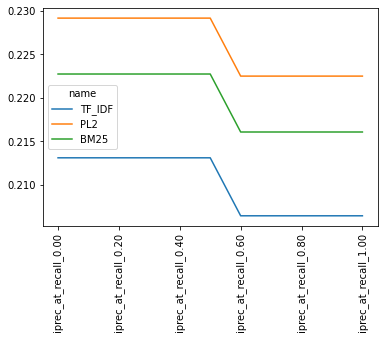

In [ ]:
hp_recall.T.plot(rot=90)

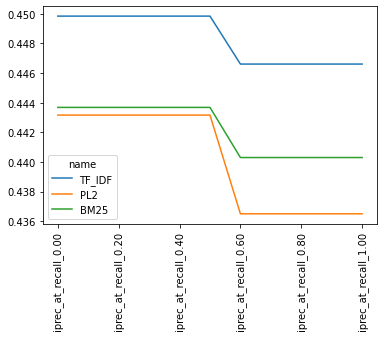

In [ ]:
np_recall.T.plot(rot=90)

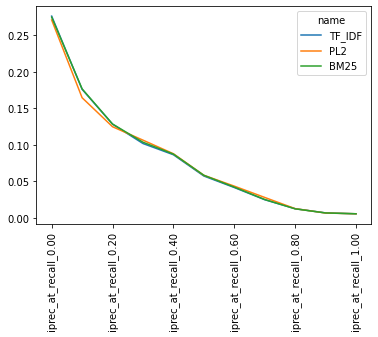

In [ ]:
td_recall.T.plot(rot=90)

# Q3 Query Expansion

Query expansion is one of the most well-known and effective techniques for improving the effectiveness of a search engine. We'll be using Terrier's Bo1 query expansion model.

See the [relevant documentation](https://pyterrier.readthedocs.io/en/latest/rewrite.html#bo1queryexpansion) about creating a QE transformer pipeline in PyTerrier using the Bo1 model.

You now have enough information to conduct Q3(a) and (b).



In [ ]:
#Rewrite the bo1 query expansion on the index
bo1 = pt.rewrite.Bo1QueryExpansion(index)

#Pass in the pipelines of the query expansion on all models
pipelineQE_PL2 = pl2 >> bo1 >> pl2
pipelineQE_TFIDF = tfidf >> bo1 >> tfidf
pipelineQE_BM25 = bm25 >> bo1 >> bm25

In [ ]:
#Print the MAP of the PL2 query expanded with hp variant
pt.Experiment(
    [pl2, pipelineQE_PL2],
    dotgov_topicsqrels.get_topics(variant="hp"),
    dotgov_topicsqrels.get_qrels(variant="hp"),
    eval_metrics=["map"],
    names=["PL2", "PL2_QE"],
    baseline = 0)

,name,map,map +,map -,map p-value
0,PL2,0.22511,NaN,NaN,NaN
1,PL2_QE,0.24231,21.0,29.0,0.252385


In [ ]:
#Print the MAP of the pl2 query expanded with np variant
pt.Experiment(
    [pl2, pipelineQE_PL2],
    dotgov_topicsqrels.get_topics(variant="np"),
    dotgov_topicsqrels.get_qrels(variant="np"),
    eval_metrics=["map"],
    names=["PL2", "PL2_QE"],
    baseline = 0)

,name,map,map +,map -,map p-value
0,PL2,0.439182,NaN,NaN,NaN
1,PL2_QE,0.444161,18.0,18.0,0.847885


In [ ]:
#Print the MAP of the pl2 query expanded with td variant
pt.Experiment(
    [pl2, pipelineQE_PL2],
    dotgov_topicsqrels.get_topics(variant="td"),
    dotgov_topicsqrels.get_qrels(variant="td"),
    eval_metrics=["map"],
    names=["PL2", "PL2_QE"],
    baseline = 0)

,name,map,map +,map -,map p-value
0,PL2,0.069525,NaN,NaN,NaN
1,PL2_QE,0.067078,30.0,45.0,0.239678


#Q3(b)

This question calls for a query-delta bar chart (See example in Lecture 5). You will need to use the ` perquery=True` option for `pt.Experiment()`. 

*Hints*: 
 - You may need a [self-join](https://www.w3schools.com/sql/sql_join_self.asp) on a dataframe.
 - You can iterate through a dataframe using [`dataframe.iterrows()`](https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/)

In [ ]:
#create an experiment dataframe to produce the map values of
#pl2 on td as per instruction per query on the query set
pl2_df = pt.Experiment(
    [pl2],
    dotgov_topicsqrels.get_topics(variant="td"),
    dotgov_topicsqrels.get_qrels(variant="td"),
    eval_metrics=["map"],
    names=["PL2"],
    perquery=True)

In [ ]:
#create the same experiment dataframe as above to produce the map
#values of the pl2 on the td as per instruction per query after the query expansion is applied
pl2_qe_df = pt.Experiment(
    [pipelineQE_PL2],
    dotgov_topicsqrels.get_topics(variant="td"),
    dotgov_topicsqrels.get_qrels(variant="td"),
    eval_metrics=["map"],
    names=["BR(PL2))"],
    perquery=True)

In [ ]:
#create a new column from the QE dataframe called 
#values_QE on the dataframe and join it on the initial dataframe
values = pl2_qe_df['value']
pl2_df = pl2_df.join(values, rsuffix='_QE')

In [ ]:
#display the new resulting dataframe
pl2_df

,name,qid,measure,value,value_QE
0,PL2,1,map,0.192260,0.142784
1,PL2,5,map,0.175462,0.188157
2,PL2,8,map,0.067678,0.057987
3,PL2,10,map,0.005882,0.004878
4,PL2,12,map,0.016414,0.014023
...,...,...,...,...,...
70,PL2,200,map,0.024660,0.030009
71,PL2,204,map,0.098070,0.065433
72,PL2,207,map,0.037714,0.040761
73,PL2,209,map,0.178180,0.166602


In [ ]:
#subtract the old map values per query from the new ones to see +ve or -ve imporvement
pl2_df['delta_value'] = pl2_df['value_QE'] - pl2_df['value']

In [ ]:
#display the final df
pl2_df

,name,qid,measure,value,value_QE,delta_value
0,PL2,1,map,0.192260,0.142784,-0.049476
1,PL2,5,map,0.175462,0.188157,0.012696
2,PL2,8,map,0.067678,0.057987,-0.009691
3,PL2,10,map,0.005882,0.004878,-0.001004
4,PL2,12,map,0.016414,0.014023,-0.002391
...,...,...,...,...,...,...
70,PL2,200,map,0.024660,0.030009,0.005349
71,PL2,204,map,0.098070,0.065433,-0.032636
72,PL2,207,map,0.037714,0.040761,0.003047
73,PL2,209,map,0.178180,0.166602,-0.011578


In [ ]:
#take the absolut of all the delta AP values on the dataframe which are >0.02 (2%)
pl2_df[pl2_df['delta_value'].abs() > 0.02]

,name,qid,measure,value,value_QE,delta_value
0,PL2,1,map,0.192260,0.142784,-0.049476
17,PL2,47,map,0.044539,0.071126,0.026587
22,PL2,58,map,0.069097,0.102276,0.033179
26,PL2,74,map,0.378118,0.290486,-0.087632
28,PL2,81,map,0.254310,0.216019,-0.038291
29,PL2,87,map,0.307605,0.336310,0.028705
31,PL2,97,map,0.219343,0.257095,0.037752
33,PL2,101,map,0.139559,0.161300,0.021741
43,PL2,133,map,0.052628,0.080159,0.027531
48,PL2,141,map,0.067058,0.042859,-0.024200


In [ ]:
#get the topics with queries
topics_td = dotgov_topicsqrels.get_topics(variant="td")

In [ ]:
import numpy as np

#create a list with the query qid matched to their texts to use for labelling on
#on the chart
query_texts = np.array(pt.get_dataset("trec-wt-2004").get_topics("td")["query"])
query_qid = np.array(pt.get_dataset("trec-wt-2004").get_topics("td")["qid"])

qid_texts = []
for each in range(0,len(query_texts)):
  qid_texts.append(query_qid[each] + ":" + query_texts[each])

print(qid_texts)

['1:electoral college', '5:american music', '8:philippines', '10:well water contamination', '12:oil petroleum resources', '15:welfare reform', '19:toxic waste', '21:substance abuse', '24:child care', '30:hiv aids', '31:origin of the universe', '33:teen pregnancy', '36:the arts in education', '37:magnetism', '40:public school standards of performance', '41:historic preservation', '45:faith based initiatives', '47:medical residency', '48:federal and state statistics', '50:money laundering', '53:telecommuting', '57:religious belief', '58:automobile emissions vehicle pollution', '63:art museums', '66:intelligence analysis', '73:solar flares', '74:skin cancer', '79:international trade', '81:mosquito control', '87:chronic pain', '96:the planet mars', '97:ufos', '99:salmon', '101:migrant farm workers', '102:diet and nutrition and weight management', '103:vanity license plates', '104:space exploration', '107:small business', '111:species identification', '115:information security', '121:identi

In [ ]:
#visualise the dataframe
pl2_df['qid_texts'] = qid_texts
pl2_df

,name,qid,measure,value,value_QE,delta_value,qid_texts
0,PL2,1,map,0.192260,0.142784,-0.049476,1:electoral college
1,PL2,5,map,0.175462,0.188157,0.012696,5:american music
2,PL2,8,map,0.067678,0.057987,-0.009691,8:philippines
3,PL2,10,map,0.005882,0.004878,-0.001004,10:well water contamination
4,PL2,12,map,0.016414,0.014023,-0.002391,12:oil petroleum resources
...,...,...,...,...,...,...,...
70,PL2,200,map,0.024660,0.030009,0.005349,200:maritime trade
71,PL2,204,map,0.098070,0.065433,-0.032636,204:endangered species
72,PL2,207,map,0.037714,0.040761,0.003047,207:annual parades
73,PL2,209,map,0.178180,0.166602,-0.011578,209:radon


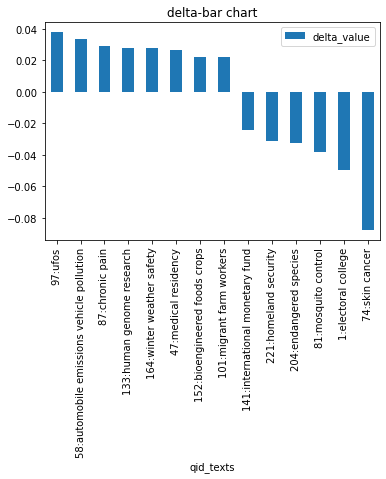

In [ ]:
#create the chart of the affected queries with all delta AP values >0.02
pl2_df[pl2_df['delta_value'].abs() > 0.02].sort_values('delta_value', 
                                                           ascending=False).plot.bar(x="qid_texts", 
                                                                                     y="delta_value", 
                                                                                     rot=90, 
                                                                                     title="delta-bar chart")

In [ ]:
#most negatively affected query
topics_td[topics_td['qid'] == '74']

,qid,query
26,74,skin cancer


In [ ]:
#most positively affected query
topics_td[topics_td['qid'] == '97']

,qid,query
31,97,ufos


In [ ]:
pipelineQE_PL2.search("ufos")['query'][0]

'applypipeline:off ufo^1.782897603 unidentifi^0.293526425 roswel^0.180836979 extraterrestri^0.155083480 forc^0.149192371 fly^0.144446932 blue^0.138189354 book^0.121246517 air^0.115234556 sight^0.114460152'

In [ ]:
pipelineQE_PL2.search("skin cancer")['query'][0]

'applypipeline:off skin^1.402936462 cancer^1.233351080 sunscreen^0.081970932 cell^0.071433646 melanoma^0.070226770 sun^0.068207895 squamou^0.067213993 carcinoma^0.063889040 uv^0.055406079 basal^0.054696254'

# Q4 Word Embeddings

Q4 asks for a word2vec-based query expansion model. Word2vec (also called word embeddings) is a shallow neural network where semantically similar words end up with similar embedding vectors.

If you haven't taken Text-as-Data, you can do some background reading about word embeddings at:
 - https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
 - https://en.wikipedia.org/wiki/Word2vec
 - https://en.wikipedia.org/wiki/Word_embedding

In general, while word2vec is still a very widely used model, note that it has been surpassed by more complex models such as BERT. But word2vec is still useful to consider in the context of query expansion.


In this part of the exercise, we will use [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html), a Python toolkit for working with a word2vec model. 

We are providing a pre-trained word2vec model that Gensim will download and open - the file is very large, so this might take a few minutes to download and a couple of minutes to load. You can read on while it opens.

In [ ]:
import gensim.downloader as api
%time model = api.load("glove-wiki-gigaword-300")

CPU times: user 1min 55s, sys: 1.15 s, total: 1min 56s
Wall time: 1min 56s


`model` is of type [gensim.models.keyedvectors.KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors).

You can think of this as a dictionary mapping string words to the vector embeddings for each word.  For example, we can get the vector for the word `'government'` as follows:

In [ ]:
emb = model.get_vector("government")
print(emb.shape)
print(emb)

(300,)
[ 2.5470e-02 -1.0216e-01 -2.8455e-01  2.8603e-01  1.9018e-01 -4.7529e-01
  1.4468e-01  1.9805e-01 -4.2931e-02 -2.9325e+00 -6.3137e-01  9.7630e-02
  1.0803e-01  5.4072e-01 -1.1834e-02  6.8399e-01  3.7241e-02 -3.8651e-01
  5.1331e-01 -4.0682e-01  3.3802e-01  3.9780e-02  1.0934e+00 -2.6993e-02
 -3.2652e-01  1.8426e-01  2.5084e-02 -1.9201e-02 -1.9761e-01  4.9951e-01
 -2.3426e-01 -1.1926e-01  4.3991e-02  3.2443e-01 -2.6306e-01 -1.7991e-01
  2.3484e-01  3.4124e-01 -3.1304e-01 -1.9777e-01 -1.9651e-01  2.8835e-01
 -1.6815e-01  3.8187e-01 -1.6562e-01 -4.0849e-01 -3.9998e-01  2.6185e-01
 -5.3972e-01  2.4353e-01  1.3366e-01 -3.0213e-01  3.7712e-01  1.8414e-01
  7.4082e-03  1.4511e-01  3.2574e-01  1.6853e-01 -1.0872e-01  1.9417e-02
 -3.2784e-01  3.9864e-01 -7.8588e-01  2.3249e-01  2.8092e-02 -4.3737e-01
  1.3954e-01 -4.0254e-01 -3.2712e-01  4.1180e-01  1.3976e-01  6.8819e-01
  3.9624e-02  2.7002e-02  2.3729e-01 -6.6964e-02  5.5686e-02  2.4415e-01
  1.2575e-03  5.1176e-01  1.3287e-01 -3.3563

As you can see, each word is represented by a 300-dimension vector.

We can also ask `model` for the most similar words to `'government'` using [`model.most_similar()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). It returns the 10 most similar words, based on the cosine similarity of their emebddings to that of `'government'`. 

See also: [Example in Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#what-can-i-do-with-word-vectors).

In [ ]:
model.most_similar("government")

[('governments', 0.6940836906433105),
 ('administration', 0.6544793844223022),
 ('authorities', 0.6283242702484131),
 ('officials', 0.6262894868850708),
 ('federal', 0.6101000905036926),
 ('opposition', 0.6081914901733398),
 ('official', 0.5788125395774841),
 ('saying', 0.5778090953826904),
 ('public', 0.575609564781189),
 ('ministry', 0.5619341135025024)]

As you can see, some words are clearly related to the original word `'government'`, including some lexical variations (`'governments'`), as well as semantically similar (`"authorities"`) words. You can also see some words that perhaps seem unrelated - probably they are highly weighted because they appeared in similar contexts to `"government"` (e.g. `"saying"`).

#Q4 Word2Vec-based Query Expansion

The next task is to use `model` to develop your custom transformer for a word2vec-based query expansion.

*Hints*:
 - Inspired by Pandas, PyTerrier has the notion of [apply functions](https://pyterrier.readthedocs.io/en/latest/apply.html) for applying transformations.
 - What to do with out-of-vocabulary (OOV) words?
 - How many similar terms to identify for each existing query term?  
 - What is the relative importance of these new terms compared to the existing query terms? e.g. you might want to give more emphasis to the original query terms. 
 - How/if to integrate the Word2Vec cosine distance into your weighting formula? 
 - How to deal with special characters not recognised by the default Terrier query parser, causing a QueryParserException (e.g `/`)?

You now have sufficient information to make a start on Q4.

In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")

#create a list to put all the special characters in 
special_characters = []

#for each token in the vocabulary take only the tokens which are greater that 1 character in length
for token in model.vocab:
  if len(token) > 1: continue

  #when finding a special character raise an error and put the character in the list
  try:
    query = pd.DataFrame([
    ["1", token]
    ], columns = ["qid", "query"])
    tf(query)
  except:
    special_characters.append(token)


#add the . and , in the list
special_characters.extend(['.', ','])

print(special_characters)

['"', '-', '(', ')', ':', "'", '?', '/', '!', '+', '~', '\\', '{', '}', '*', '^', '.', ',']


In [ ]:
#create a function to check if the term of the query has a special character in it
#return True if yes Flase if not
def containsSpecialCharacter(term, special_characters):
   for char in special_characters:
        if char in term:
             return True
   return False

#create a query expanded word to vec model
def w2vQE(query):

  #split the query on spaces
  splitted_query_terms = query["query"].split(" ")
  similar_words_dict = dict()
  final_query = list()

  #check the similarity of each query term from the splitted list
  #get the 5 most similar terms
  for qt in splitted_query_terms:
    try:
      similar_qt = model.most_similar(qt, topn=5)
    except KeyError:
      continue

    #for each term in the most similar terms check if the it contains a special
    #character and create an entry in the most similar words dictionary
    for st in similar_qt:
      term, similarity = st
      if not containsSpecialCharacter(term, special_characters) and term not in splitted_query_terms:
        similar_words_dict[term] = max(similar_words_dict.get(term, 0), similarity)


  #sort the dictionary for the most similar terms
  most_similart_qt = sorted(similar_words_dict, key=similar_words_dict.get, reverse=True)[:4]

  #extend the final query by giving a weight of 8 in each term
  final_query.extend([ (term, 8) for term in splitted_query_terms ])
  
  #extend the query with the most similar terms for each query term 
  final_query.extend([ (term, similar_words_dict.get(term)) for term in most_similart_qt ])
  final_query = " ".join(f"{term}^{weight}" for term, weight in final_query)
  print(final_query)

  return final_query

In [ ]:
#create the pipeline for the baseline model and w2v expanded model applied on the baseline
pipeline_baseline_model = pt.BatchRetrieve(index, wmodel="PL2")
pipeline_w2v_QE = pt.apply.query(w2vQE) >> pt.BatchRetrieve(index, wmodel="PL2")

#produce the evaluation
evaluation = pt.Experiment(
    [pipeline_baseline_model, pipeline_w2v_QE],
    dotgov_topicsqrels.get_topics(variant="td"),
    dotgov_topicsqrels.get_qrels(variant="td"),
    eval_metrics = ["map"],
    names = ["baseline PL2", "w2v_QE"],
    baseline = 0)

display(evaluation)

electoral^8 college^8 election^0.7704978585243225 school^0.7110487222671509 graduate^0.7072936296463013 elections^0.7058415412902832
american^8 music^8 musical^0.6985518336296082 songs^0.6906880736351013 dance^0.6395721435546875 pop^0.6392292976379395
philippines^8 philippine^0.7187957167625427 manila^0.6627101898193359 indonesia^0.6331609487533569 thailand^0.6072970628738403
well^8 water^8 contamination^8 contaminated^0.7600679397583008 both^0.750908374786377 so^0.7402366995811462 and^0.7293297648429871
oil^8 petroleum^8 resources^8 resource^0.7620533108711243 crude^0.7210761308670044 gas^0.6436548233032227 barrels^0.592186689376831
welfare^8 reform^8 reforms^0.8570170402526855 legislation^0.6427909135818481 overhaul^0.6183046102523804 policies^0.6139261722564697
toxic^8 waste^8 wastes^0.7162880897521973 poisonous^0.6769847273826599 recycling^0.6677147746086121 chemicals^0.6596251726150513
substance^8 abuse^8 substances^0.6938545107841492 sexual^0.6561464071273804 abuses^0.63980096578

,name,map,map +,map -,map p-value
0,baseline PL2,0.069525,NaN,NaN,NaN
1,w2v_QE,0.070093,31.0,44.0,0.630755


In [ ]:
#produce the evaluation
evaluation_1 = pt.Experiment(
    [pipeline_baseline_model],
    dotgov_topicsqrels.get_topics(variant="td"),
    dotgov_topicsqrels.get_qrels(variant="td"),
    eval_metrics = ["map"],
    names = ["baseline PL2"],
    perquery = True)

#produce the evaluation
evaluation_2 = pt.Experiment(
    [pipeline_w2v_QE],
    dotgov_topicsqrels.get_topics(variant="td"),
    dotgov_topicsqrels.get_qrels(variant="td"),
    eval_metrics = ["map"],
    names = ["w2v_QE"],
    perquery = True)

electoral^8 college^8 election^0.7704978585243225 school^0.7110487222671509 graduate^0.7072936296463013 elections^0.7058415412902832
american^8 music^8 musical^0.6985518336296082 songs^0.6906880736351013 dance^0.6395721435546875 pop^0.6392292976379395
philippines^8 philippine^0.7187957167625427 manila^0.6627101898193359 indonesia^0.6331609487533569 thailand^0.6072970628738403
well^8 water^8 contamination^8 contaminated^0.7600679397583008 both^0.750908374786377 so^0.7402366995811462 and^0.7293297648429871
oil^8 petroleum^8 resources^8 resource^0.7620533108711243 crude^0.7210761308670044 gas^0.6436548233032227 barrels^0.592186689376831
welfare^8 reform^8 reforms^0.8570170402526855 legislation^0.6427909135818481 overhaul^0.6183046102523804 policies^0.6139261722564697
toxic^8 waste^8 wastes^0.7162880897521973 poisonous^0.6769847273826599 recycling^0.6677147746086121 chemicals^0.6596251726150513
substance^8 abuse^8 substances^0.6938545107841492 sexual^0.6561464071273804 abuses^0.63980096578

In [ ]:
display(evaluation_1)

,name,qid,measure,value
0,baseline PL2,1,map,0.192260
1,baseline PL2,5,map,0.175462
2,baseline PL2,8,map,0.067678
3,baseline PL2,10,map,0.005882
4,baseline PL2,12,map,0.016414
...,...,...,...,...
70,baseline PL2,200,map,0.024660
71,baseline PL2,204,map,0.098070
72,baseline PL2,207,map,0.037714
73,baseline PL2,209,map,0.178180


In [ ]:
display(evaluation_2)

,name,qid,measure,value
0,w2v_QE,1,map,0.194108
1,w2v_QE,5,map,0.163695
2,w2v_QE,8,map,0.058382
3,w2v_QE,10,map,0.005714
4,w2v_QE,12,map,0.016073
...,...,...,...,...
70,w2v_QE,200,map,0.018949
71,w2v_QE,204,map,0.078121
72,w2v_QE,207,map,0.038604
73,w2v_QE,209,map,0.218533


In [ ]:
new = evaluation_1['value'] - evaluation_2['value']
new.tolist()
print(sum(i < 0 for i in new))
print(sum(i > 0 for i in new))


31
44


In [ ]:
pipeline_w2v_QE.search("ufos")['query'][0]

ufos^8 extraterrestrials^0.6519498825073242 ufo^0.6218308210372925 saucers^0.5136354565620422 extraterrestrial^0.5028389692306519


'ufos^8 extraterrestrials^0.6519498825073242 ufo^0.6218308210372925 saucers^0.5136354565620422 extraterrestrial^0.5028389692306519'

# That's all Folks

**Submission Instructions:** Complete this notebook, and answer the related questions in the Exercise 1 Quiz Instance on Moodle. As part of the Quiz, you will be asked to upload your .ipynb notebook solution and answer various corresponding questions as per the exercise specification (use File... Download .ipynb).

Your responses to the Quiz along with your ipynb notebook solution must be submitted by **Wednesday 24th February 2021, 4:30pm**.